In [1]:
import time
import psutil
import os
import random
import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt
from numpy.random import default_rng
rng = default_rng()
from matplotlib import pyplot as plt 
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
from GP_model import ExactGPModel
from utils import feature_scaling, estimate_density, gp_pdf, normalize_density
from samplers import Sampler
from clusters import Clusters


def random_direction():
    theta = 2 * np.pi * rng.random()  # Azimuthal angle [0, 2pi]
    phi = np.arccos(2 * rng.random() - 1)  # Polar angle [0, pi]
    x_dir = np.sin(phi) * np.cos(theta)
    y_dir = np.sin(phi) * np.sin(theta)
    z_dir = np.cos(phi)
    return np.array([x_dir, y_dir, z_dir])

def rescale_energies(energy_state, params):
    energy_state[0] = np.exp(energy_state[0] * params['pe']['std'] + params['pe']['mu'])
    energy_state[1] = np.exp(energy_state[1] * params['ke']['std'] + params['ke']['mu'])
    energy_state[2] = np.exp(energy_state[2] * params['ke']['std'] + params['ke']['mu'])
    return energy_state

In [2]:
# Get initial memory usage
process = psutil.Process(os.getpid())
mem_info = process.memory_info()
initial_memory = mem_info.rss

model_path = './results_chains/chains_10c_GP_pe_ke_5000iter_aug06_t1616/'

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
data_path = './data/chains'
train = ["m1.e4", "m1.e5", "m2.e4", "m3.e4", "m4.e4", "m5.e4", "m6.e4"]
params = {
    "pe": {
        "mu": [],
        "std": []
    },
    "ke":
        {
        "mu": [],
        "std": []
    }
}

for file in train:
    pe = np.load(f'{data_path}/pe_{file}.dat.npy')
    pe = np.log(pe[:-1])
    ke = np.load(f'{data_path}/ke_{file}.dat.npy')
    ke = np.log(ke[:-1])

    pe, mu_pe, std_pe = feature_scaling(pe, return_mean_std=True)
    ke, mu_ke, std_ke = feature_scaling(ke, return_mean_std=True)

    params['pe']['mu'].append(mu_pe)
    params['pe']['std'].append(std_pe)
    params['ke']['mu'].append(mu_ke)
    params['ke']['std'].append(std_ke)

standardization_params = {
    "pe": {
        "mu": np.mean(params['pe']['mu']),
        "std": np.sqrt(np.mean(np.array(params['pe']['std']) ** 2))
    },
    "ke":
        {
        "mu": np.mean(params['ke']['mu']),
        "std": np.sqrt(np.mean(np.array(params['ke']['std']) ** 2))
    }
}



# Load saved energy model weights
X = np.zeros((pe.shape[0] - 1, 3))
X[:, 0] = pe[:-1].flatten()
X[:, 1] = ke[:-1].flatten()
X[:, 2] = ke[1:].flatten()
y = normalize_density(estimate_density(X))
train_x = torch.from_numpy(X).float().cuda()
train_y = torch.from_numpy(y).float().cuda()
model = ExactGPModel(train_x, train_y, likelihood).cuda()
checkpoint = torch.load(f'{model_path}/model.pth')
model.load_state_dict(checkpoint)
model.eval()
likelihood.eval()
print('en noise:', model.likelihood.noise)
print('en lengthscale:', model.covar_module.base_kernel.lengthscale)

# Load saved phasespace model
clusters = Clusters(features='all')
likelihood_ps = gpytorch.likelihoods.GaussianLikelihood()
X_ps, cluster_name_tr = clusters.next_train(return_name=True)
y = normalize_density(estimate_density(X_ps[:, 1:])) # normalize data
train_x = torch.from_numpy(X_ps[:, 1:]).float().cuda()
train_y = torch.from_numpy(y).float().cuda()
model_ps = ExactGPModel(train_x, train_y, likelihood_ps).cuda()
checkpoint = torch.load('./results/6D_10c_aug06_t0929/model.pth')
model_ps.load_state_dict(checkpoint)
model_ps.eval()
likelihood_ps.eval()

print('6D noise:', model_ps.likelihood.noise)
print('6D lengthscale:', model_ps.covar_module.base_kernel.lengthscale)

en noise: tensor([0.3565], device='cuda:0', grad_fn=<AddBackward0>)
en lengthscale: tensor([[0.2534]], device='cuda:0', grad_fn=<SoftplusBackward0>)
6D noise: tensor([0.0752], device='cuda:0', grad_fn=<AddBackward0>)
6D lengthscale: tensor([[1.4506]], device='cuda:0', grad_fn=<SoftplusBackward0>)


In [3]:
# define initial state of the cluster based on the statistics of training data 
num_stars = 3000
means = []
stds = []
print(X.shape)
for j in range(3):
    print(X[:, j].shape)
    means.append(np.mean(X[:, j]))
    stds.append(np.std(X[:, j]))
means = np.array(means).reshape((3, 1))
stds = np.array(stds).reshape((3, 1))
initial_state_0 = np.random.normal(loc=means, scale=stds, size=(3, num_stars-1)).T
print(initial_state_0.shape)
print(means[1])

(3052, 3)
(3052,)
(3052,)
(3052,)
(2999, 3)
[-0.00060136]


In [4]:
class EMCMCSampler(Sampler):
    def __init__(self, e_pdf, num_iter=4000, num_stars=3000, random_seed=42, verbose=True):
        super().__init__(num_iter, num_stars, random_seed, verbose)
        self.count = 1
        self.e_pdf = e_pdf
        self.acc = None

    def sample(self, step_size=0.1, random_walk=False, rw_cov=0.5, burn_in_max=3000):
            """
            Generate samples from the density map using MCMC sampling*.
            * this is a modified version in which the previous value is not kept
            when a sample is rejected - the sampler iterates again until the counter
            reaches the number of desired samples.
    
            Returns
            -------
            state: array
                An array of shape (num_stars, num_dimensions) representing the final state.
            """
            # initialize the samples array and set the initial sample, declare const
            chain = initial_state_0
            check = [False] * (self.num_stars - 1)
            self.pdf_values = [0.001] * (self.num_stars - 1) # initialize pdf values to a low value
            #np.random.seed(self.random_seed)
            t0 = time.time()
            # run the MCMC sampler
            count = 1
            rejected = 0
            burn_in_count = 1
            burn_in_rejected = 0
            self.sampled_indices = []
            self.saved_states = {0: chain.copy()}
            step_size = [step_size] * self.num_dimensions if not random_walk else np.abs(np.random.normal(step_size, rw_cov, self.num_dimensions))
            while count < self.num_iter:
                burn_in_done = True if burn_in_count > burn_in_max else False
                
                available_indices = list(set(range(self.num_stars-1)) - set(self.sampled_indices))
                if not available_indices:
                    self.sampled_indices = [] # reset available indices after one round of iterations over all the features
                    available_indices = list(range(self.num_stars-1))

                idx = np.random.choice(available_indices) 
                
                # sample a new point from a truncated normal distribution centered at the current point and apply pdf to the modified sets
                #new_feature = self.generate_new_samples(mean=chain[idx], cov=step_size, size=1, truncated=True)[0]
                new_feature = self.generate_new_samples(mean=means, cov=stds, size=1, truncated=True)[0]
                prev_density = self.pdf_values[idx]
                new_density = self.e_pdf(new_feature)
                if new_density < 0:
                    new_density = 0.001
                    # if burn_in_done:
                    #     rejected += 1
                    # else:
                    #     burn_in_rejected += 1
                    # continue
                prev_joint = 1 * prev_density
                new_joint = 1 * new_density
                
                if idx > 0:
                    new_feature_l = chain[idx - 1].copy()  # left i-1 neighbour
                    new_feature_l[2] = new_feature[1] 
                    prev_density_l = self.pdf_values[idx-1]
                    new_density_l = self.e_pdf(new_feature_l)
                    if new_density_l < 0:
                        new_density_l = 0.001
                        # if burn_in_done:
                        #     rejected += 1
                        # else:
                        #     burn_in_rejected += 1
                        # continue
                    prev_joint *= prev_density_l
                    new_joint *= new_density_l

                if idx < (self.num_stars - 2):
                    new_feature_r = chain[idx + 1].copy()  # left i-1 neighbour
                    new_feature_r[1] = new_feature[2] 
                    prev_density_r = self.pdf_values[idx + 1]
                    new_density_r = self.e_pdf(new_feature_r)
                    if new_density_r < 0:
                        new_density_r = 0.001
                        # if burn_in_done:
                        #     rejected += 1
                        # else:
                        #     burn_in_rejected += 1
                        # continue
                    prev_joint *= prev_density_r
                    new_joint *= new_density_r
                    
     
                # the acceptance probability
                acceptance_prob = np.min([1.0, new_joint / prev_joint])
       
                # apply Metropolis algorithm to decide if accept the new point
                if self.verbose and burn_in_count % 200 == 0 and not burn_in_done:
                    t1 = time.time()
                    print('%d/%d burn-in steps [time: %.3f minutes]' % (burn_in_count, burn_in_max, (t1 - t0) / 60))
                    print('Acceptance rate: %.4f ' % (burn_in_count / (burn_in_count + burn_in_rejected)))  
                    
                    
                if self.verbose and count % 200 == 0 and burn_in_done:
                    t1 = time.time()
                    print('%d/%d generated samples [time: %.3f minutes]' % (count, self.num_iter, (t1 - t0) / 60))
                    print('Acceptance rate: %.4f ' % (count / (count + rejected)))
                    if count % 3000 == 0:
                        self.saved_states[count] = chain.copy()
    
                if np.random.rand() < acceptance_prob:
                    self.sampled_indices.append(idx)
                    self.pdf_values[idx] = new_density
                    if idx > 0:
                        self.pdf_values[idx - 1] = new_density_l  
                    if idx < (self.num_stars - 2):
                        self.pdf_values[idx + 1] = new_density_r  
                    if burn_in_done:
                        check[idx] = True
                        if idx > 0:
                            chain[idx - 1] = new_feature_l  
                        chain[idx] = new_feature
                        if idx < (self.num_stars - 2):
                            chain[idx + 1] = new_feature_r 
                        count += 1
                    else:
                        if idx > 0:
                            chain[idx - 1] = new_feature_l  
                        chain[idx] = new_feature
                        if idx < (self.num_stars - 2):
                            chain[idx + 1] = new_feature_r 
                        burn_in_count += 1
                    self.verbose = True
                else:
                    if burn_in_done:
                        rejected += 1
                    else:
                        burn_in_rejected += 1
                    self.verbose = False
            self.acc = count / (count + rejected)
            self.saved_states[count] = chain.copy()
            return chain

In [5]:
m_dist = np.load(f'./results/GP_mass_all_clusters_aug06_t1007/mass_distribution_48000_2024_JAN_23_t1040_M94173_seed0.npy')

(array([106., 225., 210., 210., 209., 225., 249., 237., 205., 228., 225.,
        162., 200., 218., 226., 213., 215., 203., 202., 211., 212., 193.,
        208., 188., 189., 166., 153., 177., 197., 170., 181., 155., 143.,
        156., 143., 133., 135., 113., 126., 115.,  99., 100., 125., 102.,
        100.,  71.,  69.,  61.,  59.,  65.,  61.,  58.,  60.,  43.,  49.,
         43.,  39.,  40.,  27.,  26.,  20.,  24.,  25.,  27.,  21.,  21.,
         19.,  17.,  12.,  13.,   7.,   8.,   6.,   6.,   3.,   5.,   2.,
          3.,   3.,   4.,   2.,   2.,   4.,   5.,   2.,   2.,   2.,   1.,
          0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          2.]),
 array([ 0.17651249,  0.60267678,  1.02884107,  1.45500535,  1.88116964,
         2.30733392,  2.73349821,  3.1596625 ,  3.58582678,  4.01199107,
         4.43815535,  4.86431964,  5.29048392,  5.71664821,  6.1428125 ,
         6.56897678,  6.99514107,  7.42130535,  7.84746964,  8.27363392,
         8.69979821,  9.12

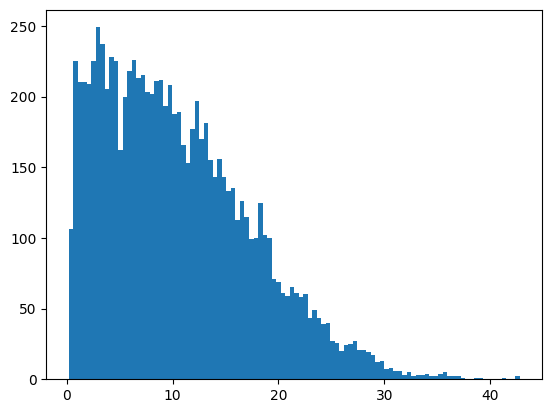

In [6]:
plt.hist(m_dist, bins=100)

In [8]:
#
N = 3000
step_size = 0.1
# mass dist with M > 0.1


# m_dist = np.load(f'./results/GP_mass_all_clusters_aug06_t1007/mass_distribution_3000stars_aug06_t1106.npy')
# mass dist with M > 0.5
seed = 40
e_pdf = lambda z: gp_pdf(z, model, likelihood, seed=seed)

burn_in_max = 3000
num_iter = 3000

# Get memory usage before starting sampling
mem_info = process.memory_info()
memory_before_sampling = mem_info.rss
print('Memory used by GP model: ', (memory_before_sampling - initial_memory) / (1024 ** 3), ' GB')

sampler = EMCMCSampler(e_pdf, num_iter=num_iter, num_stars=N)

sampler.set_bounds([[-3, 3], [-3, 3], [-3, 3]])
chain = sampler.sample(step_size=step_size, burn_in_max=burn_in_max)



Memory used by GP model:  2.0217361450195312  GB
200/3000 burn-in steps [time: 0.265 minutes]
Acceptance rate: 0.9901 
400/3000 burn-in steps [time: 0.576 minutes]
Acceptance rate: 0.9709 
600/3000 burn-in steps [time: 0.893 minutes]
Acceptance rate: 0.9390 
800/3000 burn-in steps [time: 1.242 minutes]
Acceptance rate: 0.8939 
1000/3000 burn-in steps [time: 1.582 minutes]
Acceptance rate: 0.8651 
1200/3000 burn-in steps [time: 2.009 minutes]
Acceptance rate: 0.8163 
1400/3000 burn-in steps [time: 2.453 minutes]
Acceptance rate: 0.7817 
1600/3000 burn-in steps [time: 2.972 minutes]
Acceptance rate: 0.7442 
1800/3000 burn-in steps [time: 3.591 minutes]
Acceptance rate: 0.7001 
2000/3000 burn-in steps [time: 4.449 minutes]
Acceptance rate: 0.6633 
2200/3000 burn-in steps [time: 5.467 minutes]
Acceptance rate: 0.6118 
2400/3000 burn-in steps [time: 6.482 minutes]
Acceptance rate: 0.5720 
2600/3000 burn-in steps [time: 7.515 minutes]
Acceptance rate: 0.5392 
2800/3000 burn-in steps [time: 8

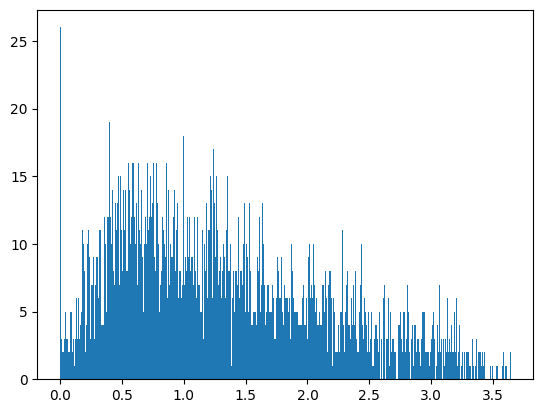

In [10]:
plt.hist(sampler.pdf_values, bins=500)
plt.show()

In [11]:
timestamp = time.strftime(f"chain_EMCMC_{N}stars_seed{seed}_iter{num_iter+burn_in_max}_acc{round(sampler.acc*100,2)}_REV_2024_%d_t%H%M", time.gmtime())

# Get memory after sampling
mem_info = process.memory_info()
memory_final = mem_info.rss #
print('Memory used by sampling algorithm: ', (memory_final - memory_before_sampling) / (1024 ** 3), ' GB')

np.save(f'{model_path}/{timestamp}', chain)


Memory used by sampling algorithm:  -1.9273605346679688  GB


In [12]:
sampler.saved_states.keys()

dict_keys([0, 3000])

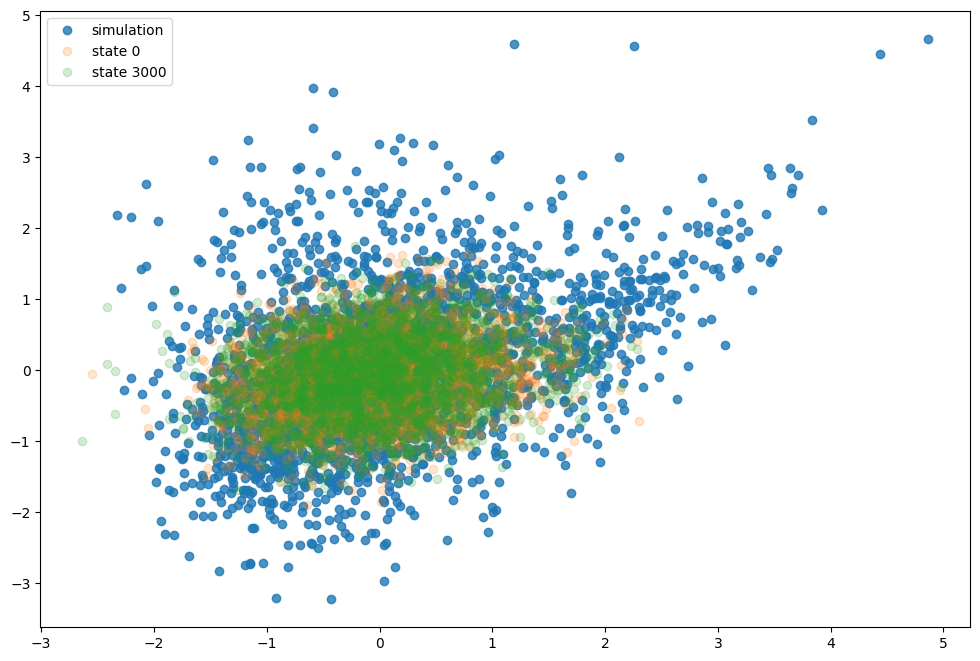

In [13]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12,8))
# plt.plot(initial_state_0[:,0],initial_state_0[:,1], 'o', label='initial chain')
plt.plot(X[:,0], X[:,1], 'o', alpha=0.8, label='simulation')
for iter, state in sampler.saved_states.items():
    plt.plot(state[:,0],state[:,1], 'o',alpha=0.2, label=f'state {iter}')
#plt.plot(chain[:,0],chain[:,1], 'o', label='EMCMC')


plt.legend()
plt.show()


In [14]:
# data
clusters = Clusters(features='all')
X = clusters.next_train()
# X = clusters.next_train()
# normalize data
y = normalize_density(estimate_density(X, k=50))
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
train_x = torch.from_numpy(X).float().cuda()
train_y = torch.from_numpy(y).float().cuda()
model = ExactGPModel(train_x, train_y, likelihood).cuda()
model.eval()
likelihood.eval()
seed = 0
pdf = lambda z: gp_pdf(z, model, likelihood, seed=seed)

In [15]:
#m_dist = list(np.load(f'./results/GP_mass_all_clusters_aug06_t1007/mass_distribution_48000_M0.1_2024_JAN_23_t1714_M26406_seed0.npy'))
ps_pdf = lambda z: gp_pdf(z, model_ps, likelihood_ps)
chain = np.load(model_path + 'chain_EMCMC_3000stars_seed40_iter6000_acc27.79_REV_2024_18_t2002.npy')

In [16]:
from tqdm import tqdm
N = chain.shape[0] + 1
Nc = 1000
cluster = np.zeros((N,7))
cluster[0] = X_ps[0]
max_jump_ = 1.5
m_dist = list(m_dist)
for i in tqdm(range(0, N-1)):
    energies = chain[i].copy()
    uij, kei, kej = rescale_energies(energies, standardization_params)
    #print(uij, kei, kej)
    mi, xi, yi, zi, vxi, vyi, vzi = cluster[i]
    mj = random.sample(m_dist, 1)[0]
    #print(mi, xi, yi, zi, vxi, vyi, vzi)
    ri = [xi, yi, zi]
    rij_mag = 999
    max_jump = max_jump_
    while rij_mag > max_jump:
        rij_mag = mi * mj / uij
        mj = random.sample(m_dist, 1)[0]
        # sometimes large masses lead to expected jump distances that exceed the threshold, so we slightly decrease the mass to accelerate the sampling
        if mi > 0.2:
            mi -= 0.001 

    vj_mag = np.sqrt(2 * kej / mj)
    candidates = np.zeros((Nc, 7))
    dirs = np.zeros((Nc, 3))
    for idx in range(Nc):
        # get random directions by sampling spherical coordinates
        r_dir = random_direction()
        v_dir = random_direction()
        
        rj = ri + rij_mag * r_dir
        vj = vj_mag * v_dir
        candidates[idx] = [mj[0], rj[0], rj[1], rj[2], vj[0], vj[1], vj[2]]
        dirs[idx] = r_dir

    probs = ps_pdf(candidates[:, 1:])
    #probs = pdf(candidates)
    best = np.argmax(probs)
    cluster[i+1] = candidates[best]

100%|██████████| 2999/2999 [14:18<00:00,  3.49it/s]


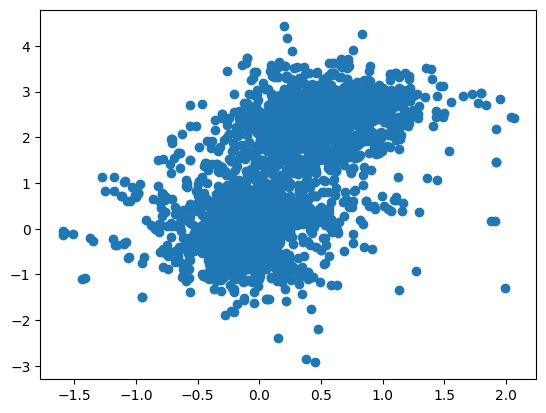

In [17]:
plt.plot(cluster[:,2], cluster[:,1], 'o')
plt.show()

In [18]:
timestamp = time.strftime(f"cluster_EMCMC_M_0.2_Nc_{Nc}_J_{max_jump_}_iter3000_REV2024_%d_t%H%M", time.gmtime())

# # Get memory after sampling
# mem_info = process.memory_info()
# memory_final = mem_info.rss #
# print('Memory used by sampling algorithm: ', (memory_final - memory_before_sampling) / (1024 ** 3), ' GB')

np.save(f'{model_path}/{timestamp}', cluster)